# Ocean Acidification: pH

```{glue:figure} average_map
:scale: 50%
:align: center
```

```{glue:figure} average_timeseries
:scale: 50%
:align: center
```

Figure. Change in pH from hindcast. The map (top) shows the change in mean surface pH in the vicinity of Palau over the period 1993- 2022. The grey line is the Palau EEZ.  The line plot (bottom) shows the change in mean surface pH averaged over the area within the top plot. The solid black line represents the trend, which is statistically significant (p < 0.05). The colored dots represent the 10 years with the lowest pH on record.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import os.path as op
import sys

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from myst_nb import glue 

sys.path.append("../../../../indicators_setup")

from ind_setup.plotting_int import plot_timeseries_interactive, plot_oni_index_th
from ind_setup.plotting import plot_base_map, plot_map_subplots, add_oni_cat, plot_bar_probs, fontsize


sys.path.append("../../../functions")
from data_downloaders import download_oni_index



## Setup

Define area of interest

In [5]:
#Area of interest
lon_range  = [129.4088, 137.0541]
lat_range = [1.5214, 11.6587]

EEZ shapefile

In [6]:
path_figs = "../../../matrix_cc/figures"

In [7]:
shp_f = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')
shp_eez = gpd.read_file(shp_f)

### Load Data

In [8]:
data_xr = xr.open_dataset(op.join(os.getcwd(), '..', '..','..', 'data/data_phyc_o2_ph.nc')).isel(depth = 0)
dataset_id = 'ph'
label = 'pH'

## Analysis

### Plotting

#### Average

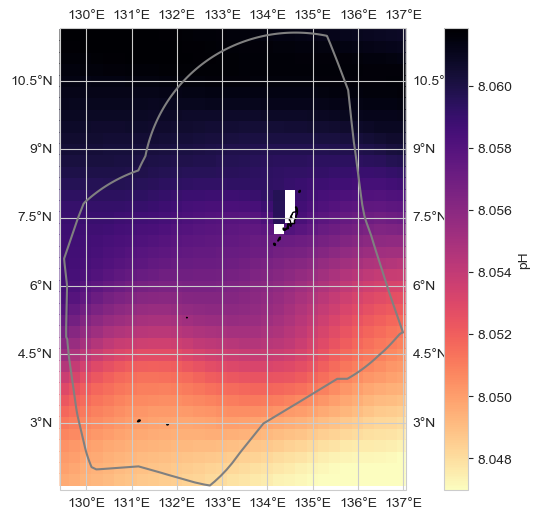

In [9]:
fig, ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
im = ax.pcolor(data_xr.longitude, data_xr.latitude, data_xr.mean(dim='time')[dataset_id], transform=ccrs.PlateCarree(), 
                cmap = 'magma_r', 
                vmin = np.nanpercentile(data_xr.mean(dim = 'time')[dataset_id], 1), 
                vmax = np.nanpercentile(data_xr.mean(dim = 'time')[dataset_id], 99))
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, label= label)
glue("average_map", fig, display=False)
plt.savefig(op.join(path_figs, 'F14_pH_mean_map.png'), dpi=300, bbox_inches='tight')


#### Annual average

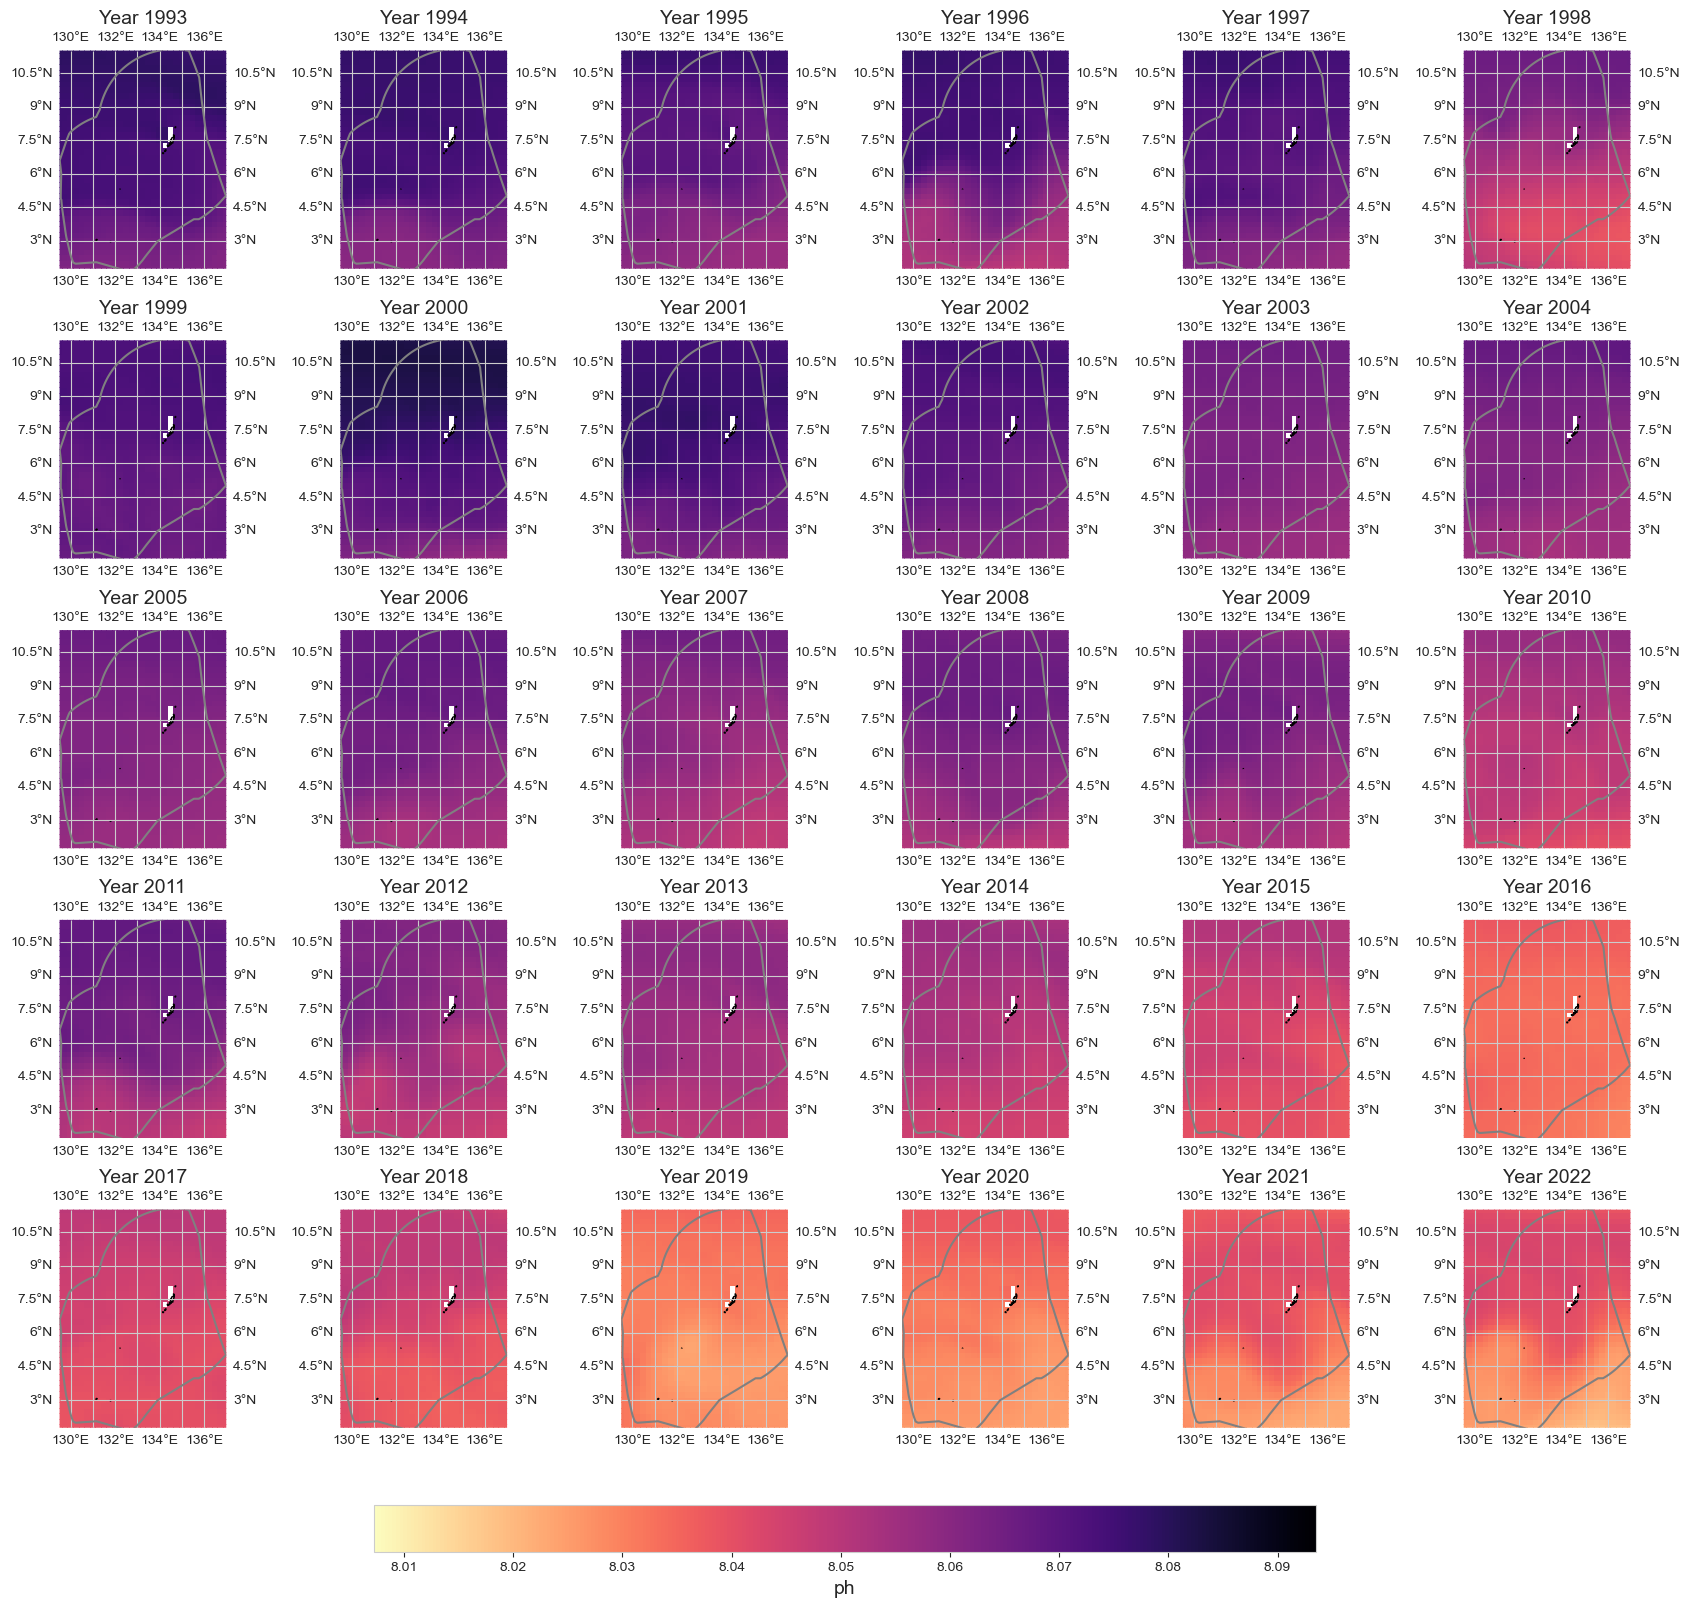

In [7]:
data_y = data_xr.resample(time='1YE').mean()
im = plot_map_subplots(data_y, dataset_id, shp_eez = shp_eez, cmap = 'magma_r', 
                  vmin = np.nanpercentile(data_xr.min(dim = 'time')[dataset_id], 1), 
                  vmax = np.nanpercentile(data_xr.max(dim = 'time')[dataset_id], 99),
                  cbar = 1)

#### Annual anomaly

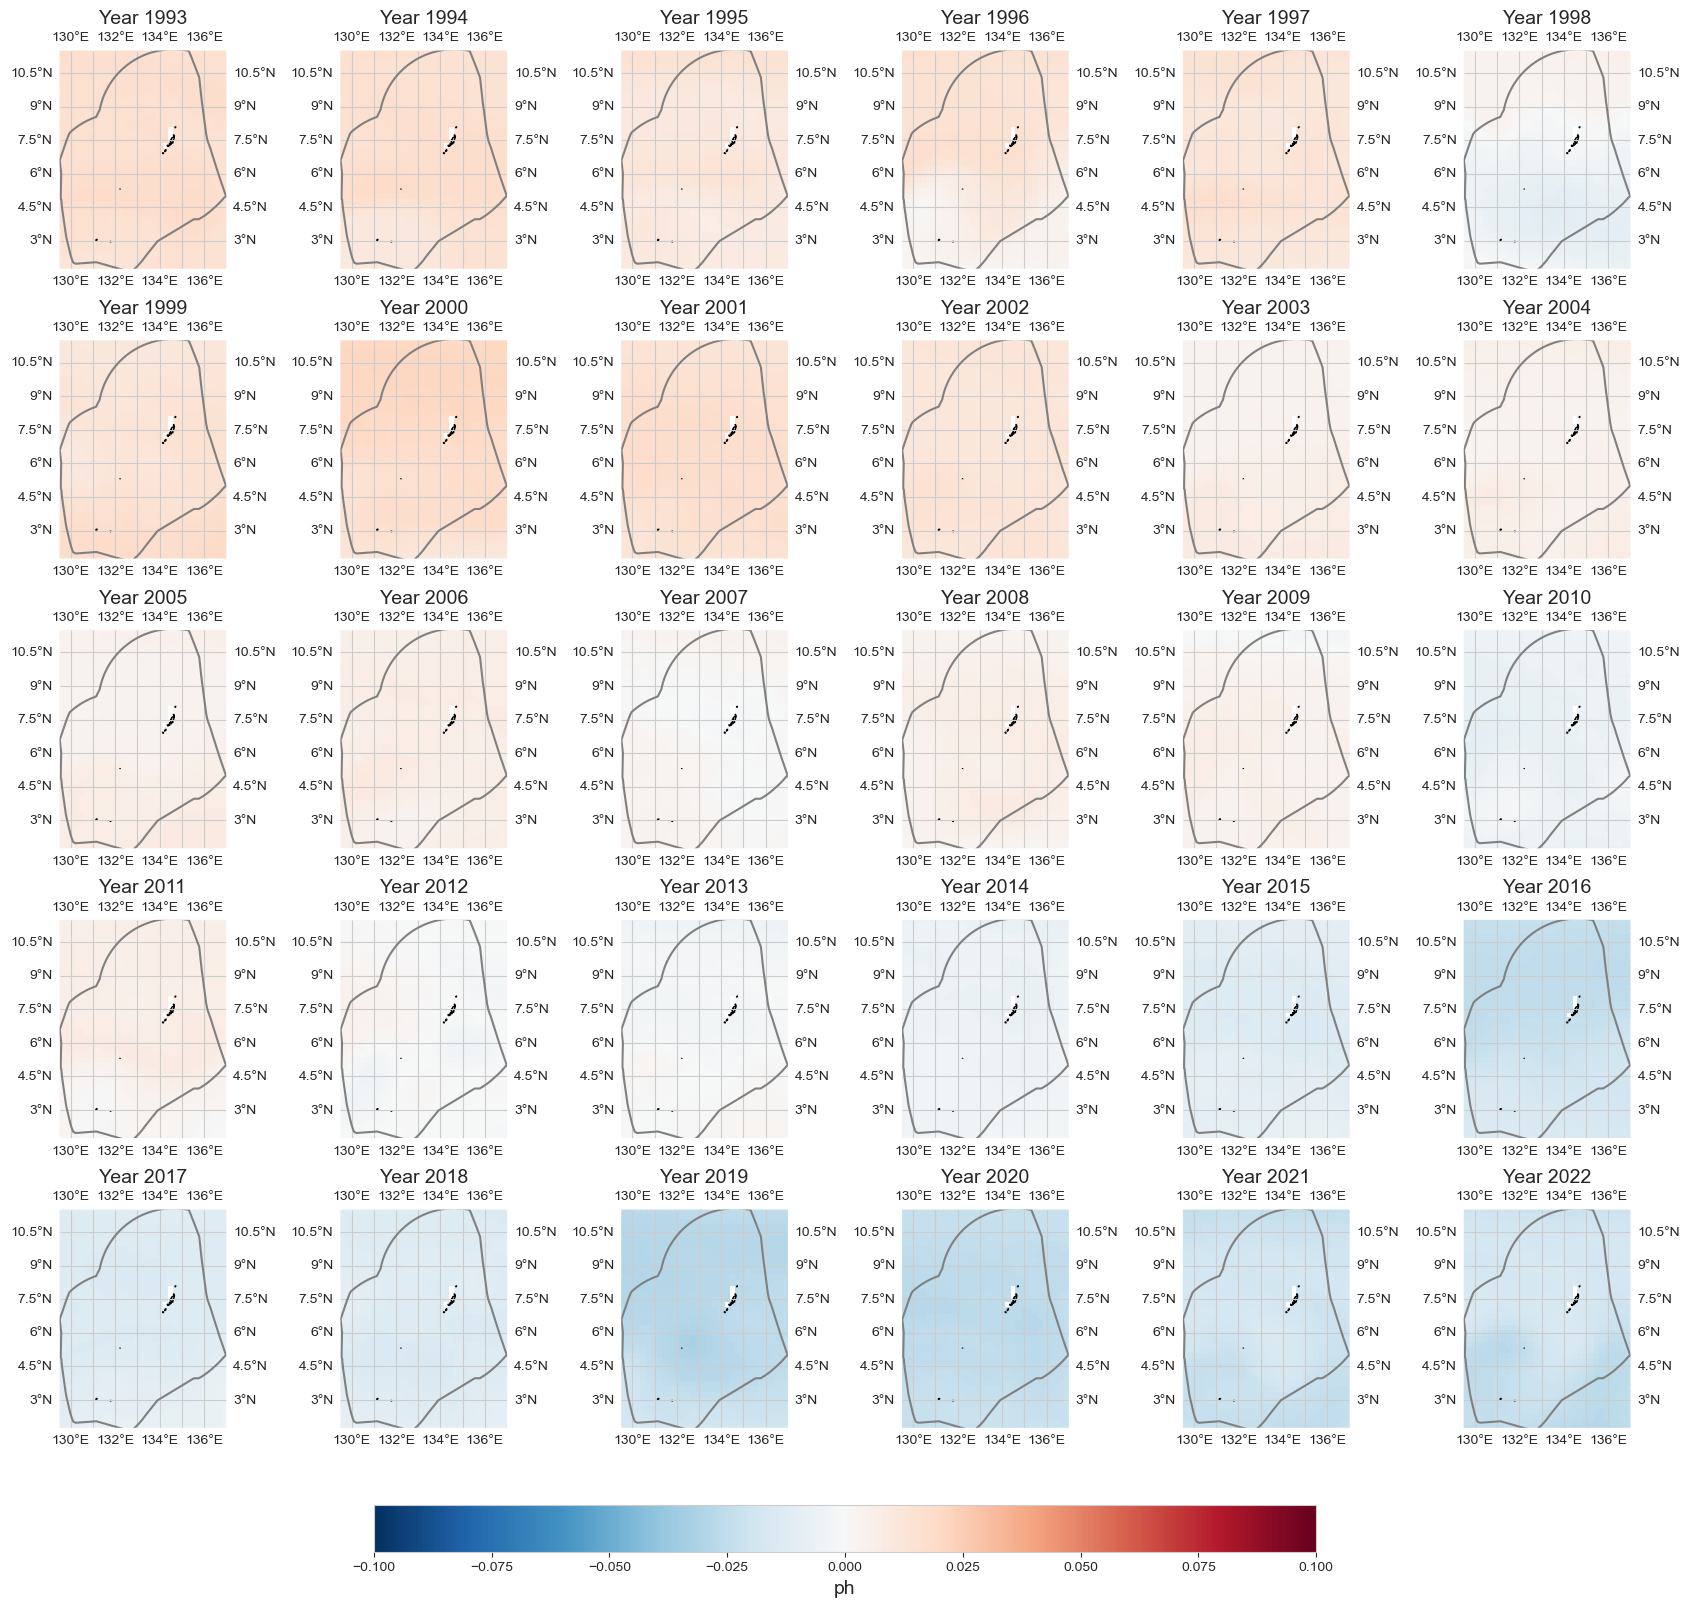

In [8]:
data_an = data_y - data_xr.mean(dim='time')
fig = plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-.1, vmax=.1, cbar = 1)

#### Average over area

In [10]:
dict_plot = [{'data' : data_xr.mean(dim = ['longitude', 'latitude']).to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : 'pH - MEAN AREA'},]

In [11]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None, figsize = (25, 12));
fig.write_html(op.join(path_figs, 'F14_pH_mean_trend.html'), include_plotlyjs="cdn")


#### Top 10 years

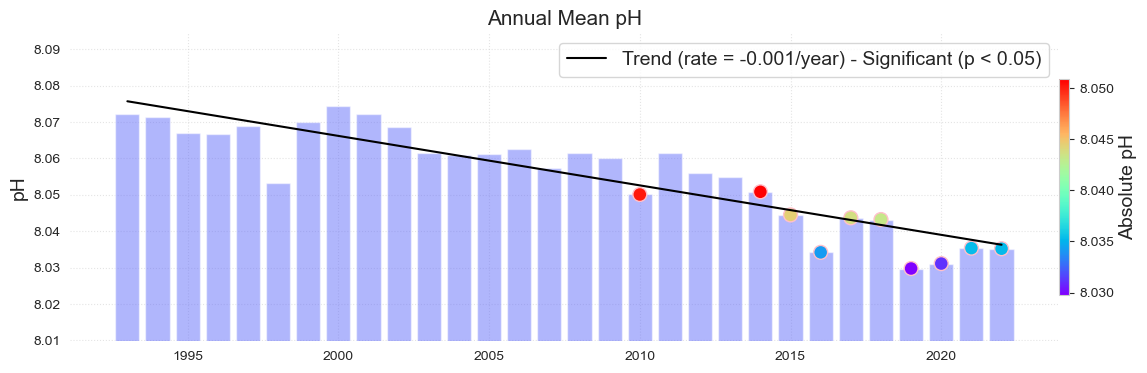

In [ ]:
data_mean = data_xr.mean(dim = ['longitude', 'latitude']).to_dataframe()
data_mean = data_mean.resample('YE').mean()
top_10 = data_mean.sort_values(by='ph', ascending=True).head(10)

fig, ax, trend = plot_bar_probs(x=data_mean.index.year, y=data_mean.ph, trendline=True,
                                y_label='pH', figsize=[15, 4], return_trend=True)
ax.set_ylim(data_mean.ph.min()-.02, data_mean.ph.max()+.02)
im = ax.scatter(top_10.index.year, top_10.ph,
                c=top_10.ph.values, s=100, ec='pink', cmap='rainbow', label='Top 10 years')
plt.colorbar(im, pad=0, shrink=.7).set_label('Absolute pH', fontsize=fontsize)
glue("average_timeseries", fig, display=False)
ax.set_title('Annual Mean pH', fontsize=15);


#### Timeseries at a given point

In [36]:
loc = [7.37, 134.7]
dict_plot = [{'data' : data_xr.sel(longitude=loc[1], latitude=loc[0], method='nearest').to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : f'{label} at [{loc[0]}, {loc[1]}]'},]

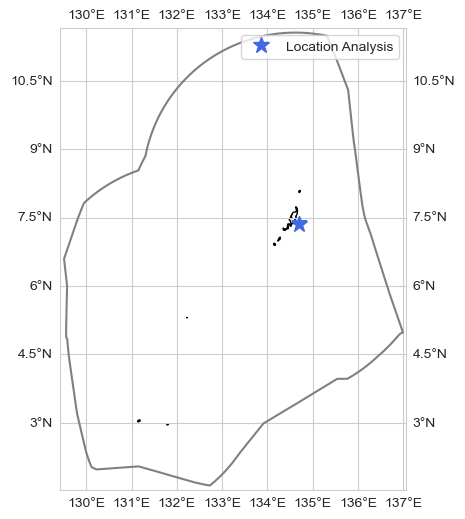

In [ ]:
fig, ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
ax.plot(loc[1], loc[0], '*', markersize = 12, color = 'royalblue', transform=ccrs.PlateCarree(), label = 'Location Analysis')
ax.legend()

In [38]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None, figsize = (25, 12));

### ONI index analysis

In [39]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
df1 = download_oni_index(p_data)

In [40]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

Group by ONI category

In [41]:

df1 = add_oni_cat(df1, lims = lims)
df1['ONI'] = df1['oni_cat']
data_xr['ONI'] = (('time'), df1.iloc[np.intersect1d(data_xr.time, df1.index, return_indices=True)[2]].ONI.values)
data_xr['ONI_cat'] = (('time'), np.where(data_xr.ONI < lims[0], -1, np.where(data_xr.ONI > lims[1], 1, 0)))
data_oni = data_xr.groupby('ONI_cat').mean()

#### Average

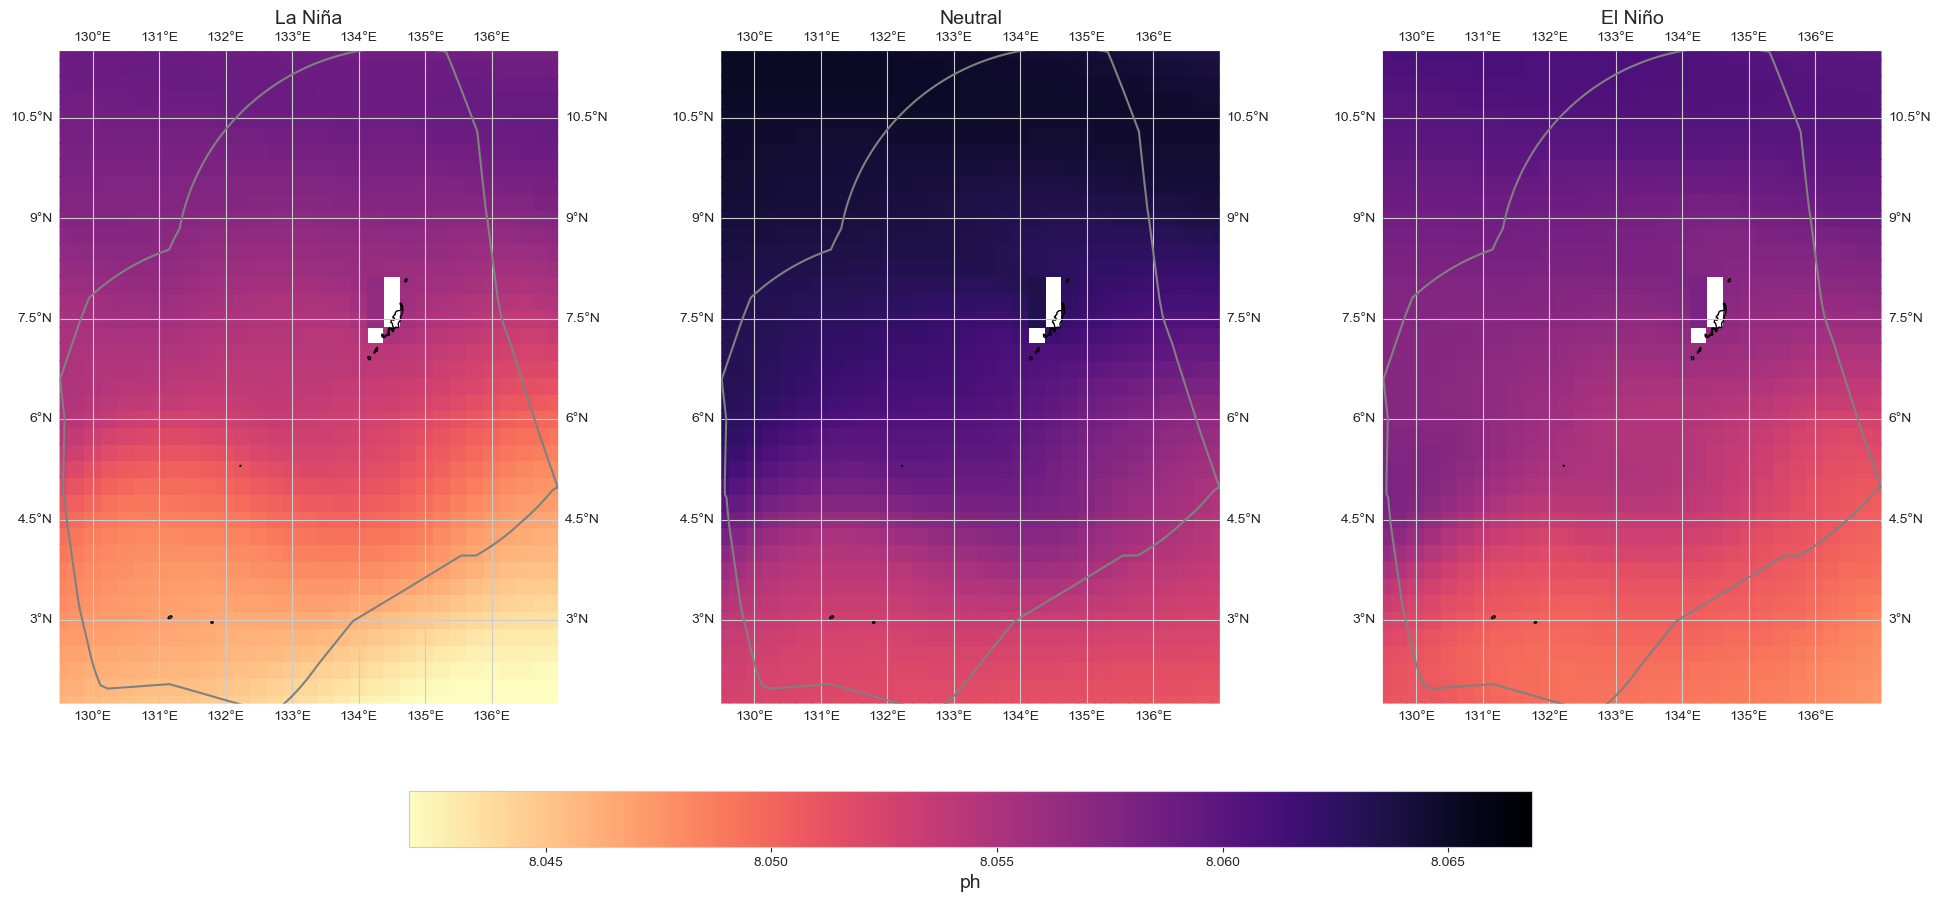

In [42]:
fig = plot_map_subplots(data_oni, dataset_id, shp_eez = shp_eez, cmap = 'magma_r', 
                  vmin = np.nanpercentile(data_xr.mean(dim = 'time')[dataset_id], 1)-.005, 
                  vmax = np.nanpercentile(data_xr.mean(dim = 'time')[dataset_id], 99) + .005,
                  sub_plot= [1, 3], figsize = (20, 9), cbar = True, cbar_pad = 0.1,
                  titles = ['La Niña', 'Neutral', 'El Niño'],)

plt.savefig(op.join(path_figs, 'F14_pH_ENSO.png'), dpi=300, bbox_inches='tight')


#### Anomaly

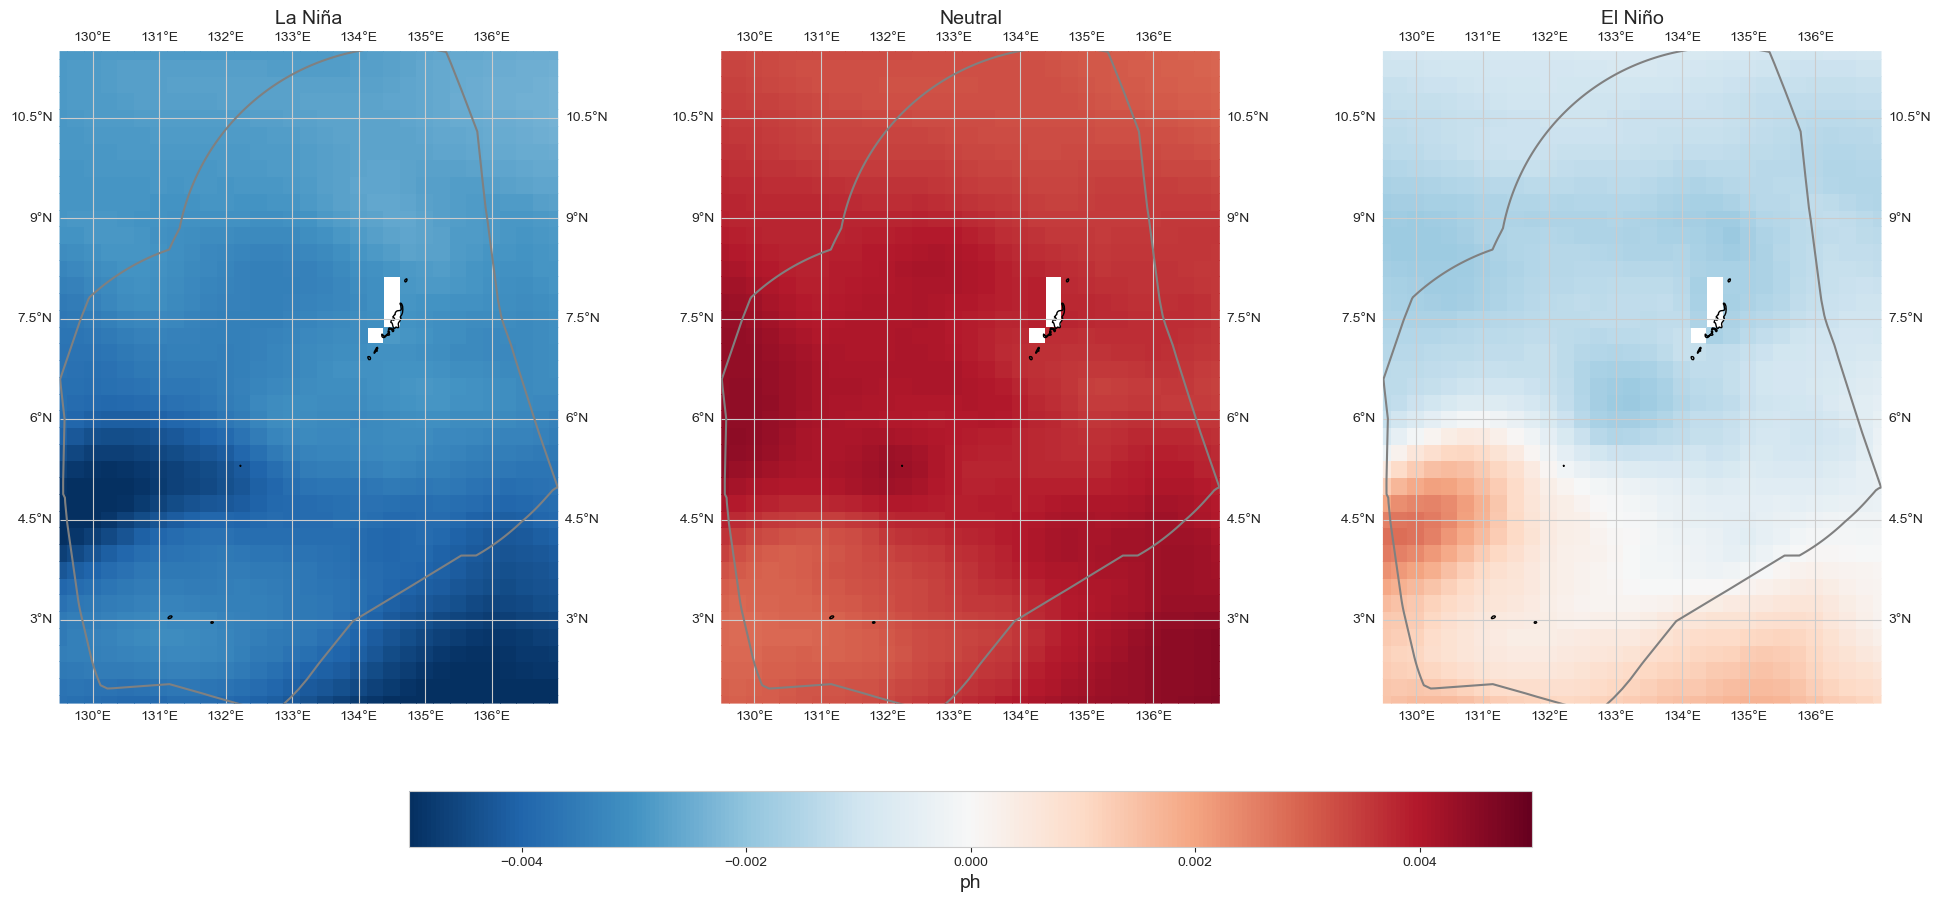

In [43]:
data_an = data_oni - data_xr.mean(dim='time')
fig = plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-.005, vmax=.005,
                  sub_plot= [1, 3], figsize = (20, 9), cbar = True, cbar_pad = 0.1,
                  titles = ['La Niña', 'Neutral', 'El Niño'],)